# Import Statements

In [1]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")

# Cleaning

In [2]:
path = 'C:\\Users\\missn\\Documents\\Thinkful\\Python Notebooks\\2 Bootcamp\\Output_Clean.csv'
output_clean = pd.read_csv(path)

In [3]:
output_clean['Site'].value_counts()

Independent      79
Cameroon Post    20
Sun News         20
Daily Trust      20
Vanguard         20
The Nation       20
Tribune          15
Bareta News      14
Name: Site, dtype: int64

## Vanguard (0-19)

In [4]:
output_clean['Document'] = output_clean['Document'].str.replace(r'\r.+\r',' ')
output_clean['Document'] = output_clean['Document'].str.replace(u'\xa0',' ')
output_clean['Document'] = output_clean['Document'].str.replace(r'Related +$','')

## Sun News (20-39)

In [5]:
output_clean['Document'] = output_clean['Document'].str.replace(r'\(adsbygoogle = window\.adsbygoogle \|\| \[\]\)\.push\(\{\}\);','')
output_clean['Document'] = output_clean['Document'].str.replace(r'function insertAfter.+$','')
output_clean['Document'] = output_clean['Document'].str.replace(r'READ ALSO: .+$','')

## The Nation (40-59)

In [6]:
output_clean['Document'] = output_clean['Document'].str.replace(r'Do you get a good or bad response from your wife after making love.+$','')

## Tribune (60-74)

In [7]:
output_clean['Document'] = output_clean['Document'].str.replace(r'Courtesy:.+$','')
output_clean['Document'] = output_clean['Document'].str.replace(r'Share this:.+$','')

## Daily Trust (75-94)

In [8]:
output_clean['Document'] = output_clean['Document'].str.replace(u'\\u200e','')
output_clean['Document'] = output_clean['Document'].str.replace(r'\/ AFP PHOTO','')
output_clean['Document'] = output_clean['Document'].str.replace(r'#notatarget.+$','')

## Independent (95-173)

Some articles returned arent even related to the search terms. See 145-150. 

In [9]:
output_clean['Document'] = output_clean['Document'].str.replace(r'window\._taboola.+$','')

## Bareta News (174-187)

177 and 178 are full of Twitter handles, links, and other contact information. James Agbor, Bareta News Analyst is cited several different ways. 

## Cameroon Post (188-207)

In [10]:
output_clean['Document'] = output_clean['Document'].str.replace(r'Posted in:.+$','')

## Final Cleaning Step

In [11]:
output_clean['Document'] = output_clean['Document'].str.lower()

In [12]:
output_clean['Document'] = output_clean['Document'].str.replace(r'[^\w\s]',' ')

## Summary Descriptive Statistics

In [13]:
output_clean['Search Term'].value_counts()

Boko Haram    108
Ambazonia     100
Name: Search Term, dtype: int64

In [14]:
output_clean.loc[output_clean['Document'].str.contains('boko haram')].shape[0]

73

In [15]:
output_clean.loc[output_clean['Document'].str.contains('ambazonia')].shape[0]

52

# Modeling

In [16]:
X = output_clean['Document']
X_train, X_test = train_test_split(X, test_size = 0.25, stratify = output_clean['Search Term'])

vectorizer = TfidfVectorizer(analyzer = 'word', stop_words = 'english', min_df = 5, max_df = 0.8, ngram_range = (1,2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [17]:
X_train_tfidf.shape

(156, 1837)

In [18]:
X_test_tfidf.shape

(52, 1837)

In [19]:
terms = vectorizer.get_feature_names()
ntopics = 10
n_top_words = 5

def word_topic(tfidf, solution, wordlist):
    words_by_topic = tfidf.T * solution
    components = pd.DataFrame(words_by_topic, index = wordlist)  
    return components

def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index = np.repeat(n_topics, n_top_words, axis = 0)
    topwords = pd.Series(index = index)
    
    for column in range(components.shape[1]):
        sortedwords = components.iloc[:,column].sort_values(ascending = False)
        chosen = sortedwords[:n_top_words]
        chosenlist = chosen.index + " " + round(chosen,2).map(str) 
        topwords.loc[column] = chosenlist
    return(topwords)

topwords = pd.DataFrame()

#### Check whether the other models include normalization as a built-in step.
#### Find component(s) that has/have insurgency as a top word - which is about Ambazonia and which is about Boko Haram? Look for individual articles that have high value(s) for the component(s). If they've been normalized, you can judge them against each other. Note which has the highest value for the component. 

## Model 1A: Latent Semantic Analysis. 

In [20]:
svd = TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))
X_train_lsa = lsa.fit_transform(X_train_tfidf)

components_lsa = word_topic(X_train_tfidf, X_train_lsa, terms)
topwords['LSA']=top_words(components_lsa, n_top_words) 

## Model 1B: Latent Dirichlet Allocation

In [21]:
lda = LatentDirichletAllocation(ntopics)
X_train_lda = lda.fit_transform(X_train_tfidf)

components_lda = word_topic(X_train_tfidf, X_train_lda, terms)
topwords['LDA']=top_words(components_lda, n_top_words)

## Model 1C: Non-Negative Matrix Factorization

In [22]:
nmf = NMF(ntopics)
X_train_nmf = nmf.fit_transform(X_train_tfidf)

components_nmf = word_topic(X_train_tfidf, X_train_nmf, terms)
topwords['NMF']=top_words(components_nmf, n_top_words) 

In [23]:
topwords

,LSA,LDA,NMF
0,said 5.09,diaspora 0.78,cameroon 1.08
0,cameroon 4.86,america 0.41,biya 0.6
0,nigeria 4.22,africans 0.4,regions 0.51
0,government 4.07,said 0.36,nigeria 0.43
0,people 3.86,needs 0.36,speaking 0.43
1,boko 2.79,apc 0.26,boko 1.16
1,haram 2.79,akwa 0.17,boko haram 1.16
1,boko haram 2.79,ibom 0.17,haram 1.16
1,insurgents 2.49,akwa ibom 0.17,jihadists 0.62
1,maiduguri 1.31,pdp 0.15,said 0.56


# Comparison & Hyperparameter Tuning

In [24]:
df_topwords = pd.DataFrame(topwords)
df_topwords.head()

,LSA,LDA,NMF
0,said 5.09,diaspora 0.78,cameroon 1.08
0,cameroon 4.86,america 0.41,biya 0.6
0,nigeria 4.22,africans 0.4,regions 0.51
0,government 4.07,said 0.36,nigeria 0.43
0,people 3.86,needs 0.36,speaking 0.43


In [25]:
output_clean.loc[output_clean['Document'].str.contains('boko')].shape

(74, 5)

In [26]:
for column in df_topwords.columns: 
    df_topwords[column] = df_topwords[column].str.replace('\s\d.*', '')

words_allmethods = []
for column in df_topwords.columns: 
    words_allmethods.append(df_topwords[column].tolist())
    
words_allmethods_flat = [string for sublist in words_allmethods for string in sublist]
print(words_allmethods_flat)

['said', 'cameroon', 'nigeria', 'government', 'people', 'boko', 'haram', 'boko haram', 'insurgents', 'maiduguri', 'insurgents', 'maiduguri', 'cameroon', 'farmers', 'attacked', 'president', 'buhari', 'presidential', 'governor', 'said', 'cameroon', 'initiative', 'collaboration', 'development', 'operation', 'cameroun', 'southern', 'cameroons', 'schools', 'school', 'nigeria', 'said', 'trump', 'refugees', 'governor', 'trump', 'macron', 'posted', '2018', 'conference', 'army', 'soldiers', 'jihadists', 'military', 'boko haram', 'posted', '2018', 'court', 'police', 'august', 'diaspora', 'america', 'africans', 'said', 'needs', 'apc', 'akwa', 'ibom', 'akwa ibom', 'pdp', 'charge', 'duty', 'nigerians', 'fraud', 'allegations', 'lagos', 'immediate', 'reports', 'governor', 'state', 'conference', 'said', 'communities', 'community', 'plan', 'initiative', 'members', 'collaboration', 'said', 'boko haram', 'president', 'posted', 'court', '2018', 'buhari', 'said', 'posted', 'cameroon', 'haram', 'boko', 'cam

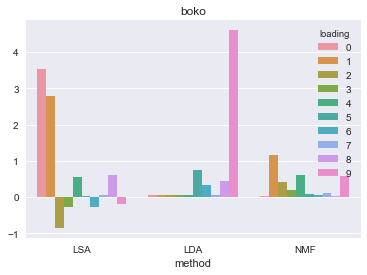

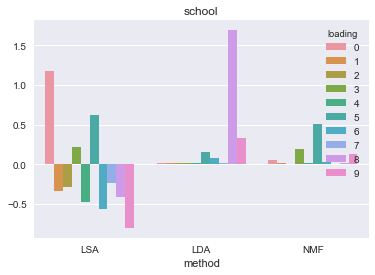

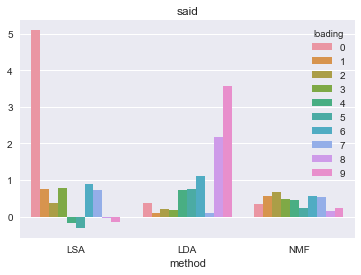

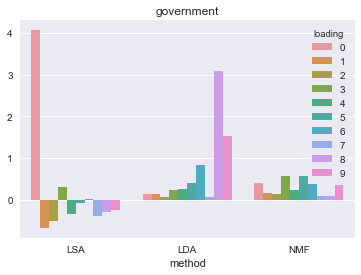

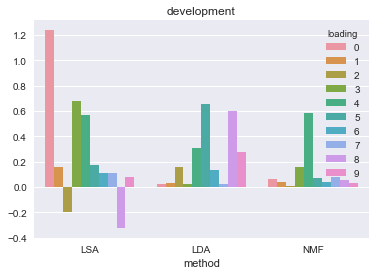

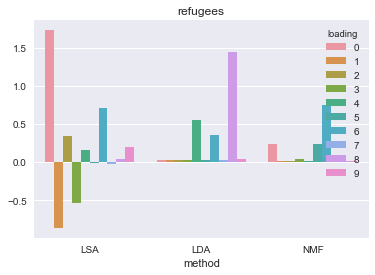

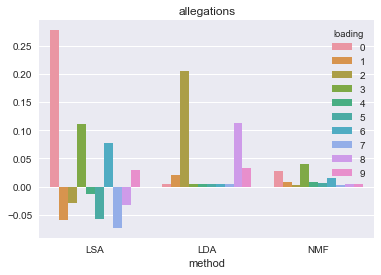

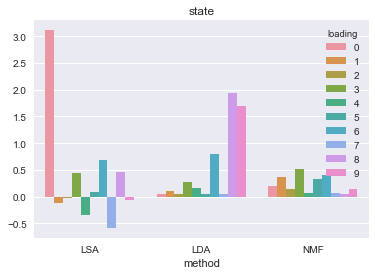

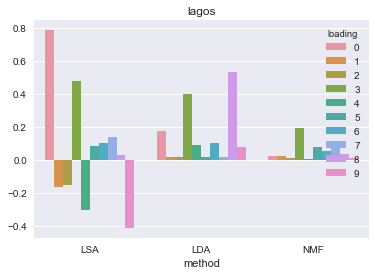

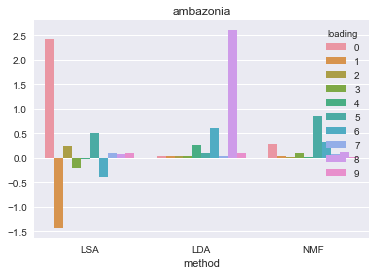

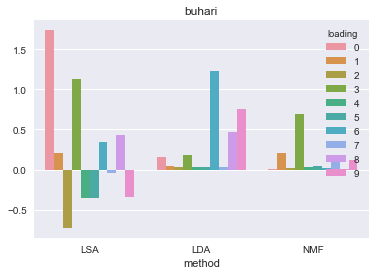

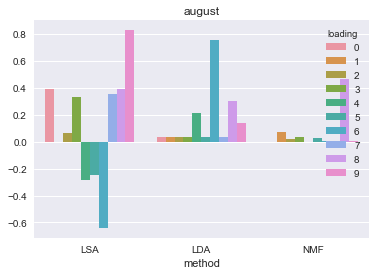

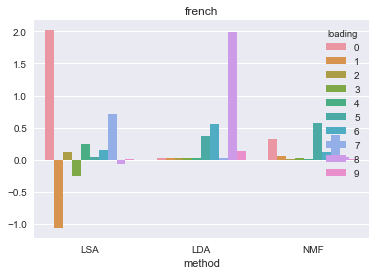

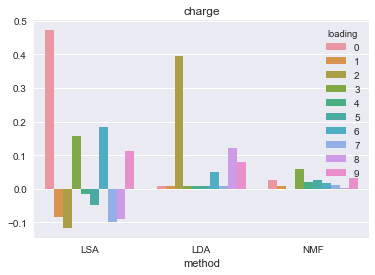

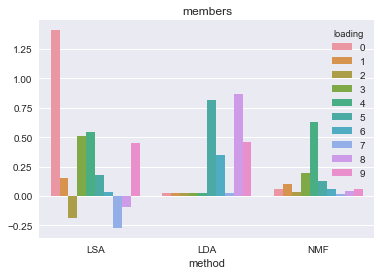

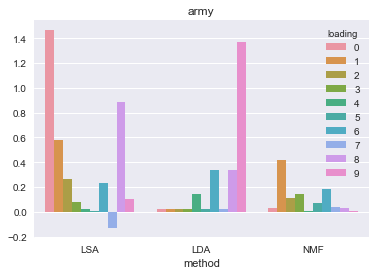

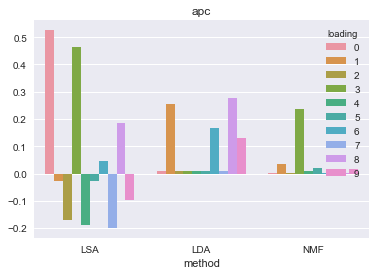

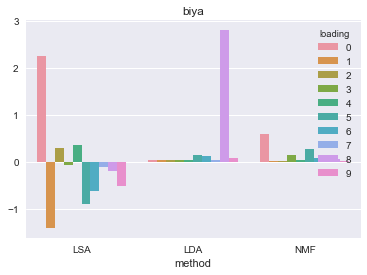

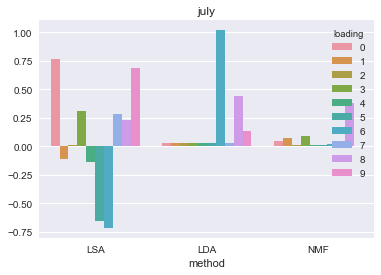

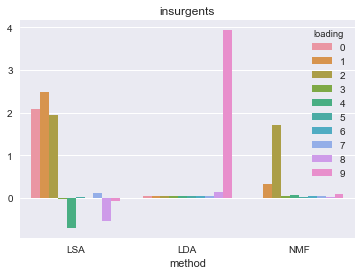

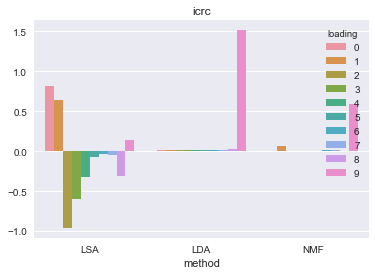

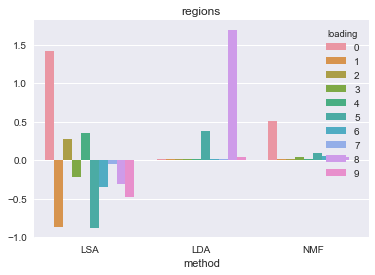

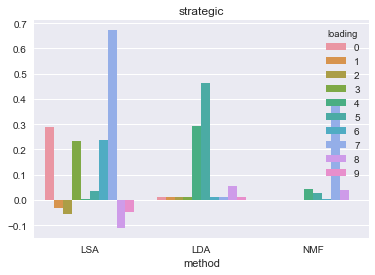

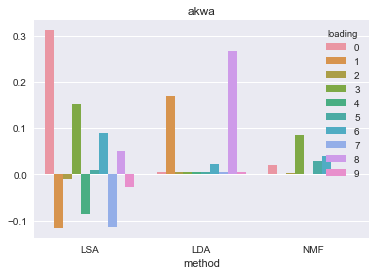

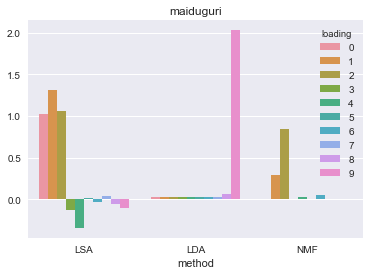

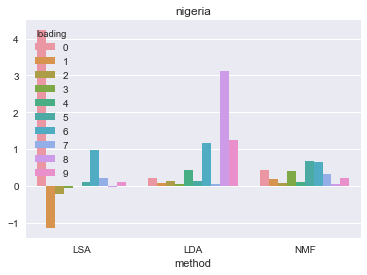

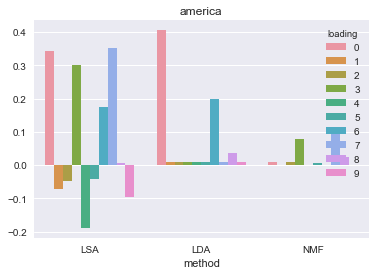

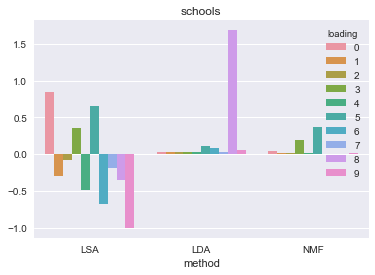

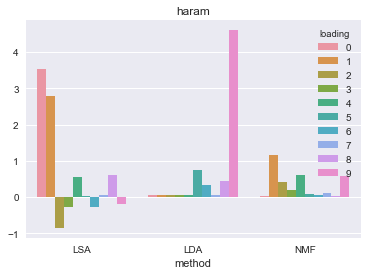

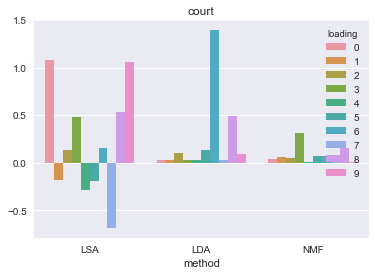

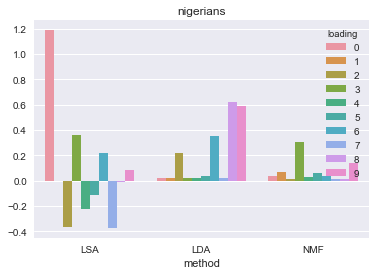

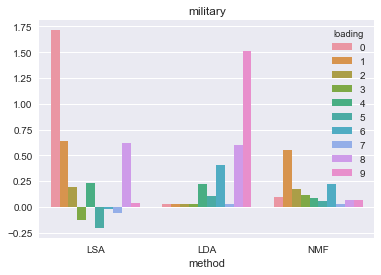

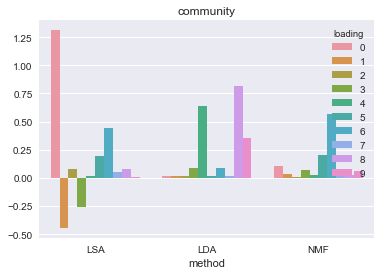

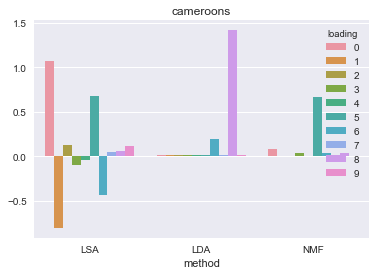

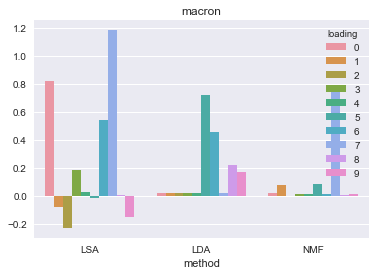

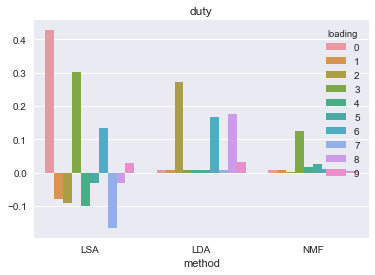

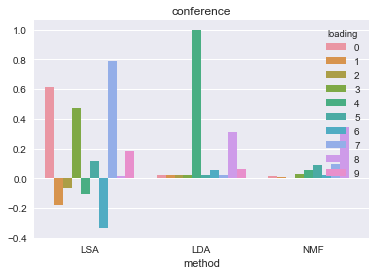

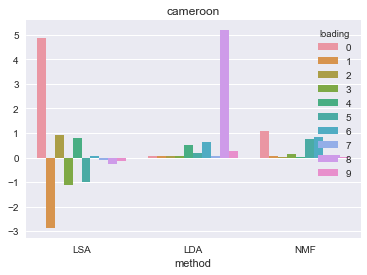

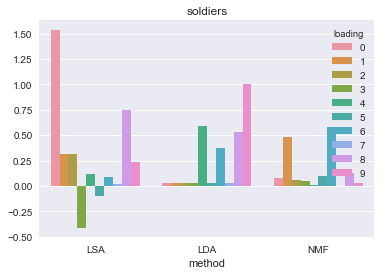

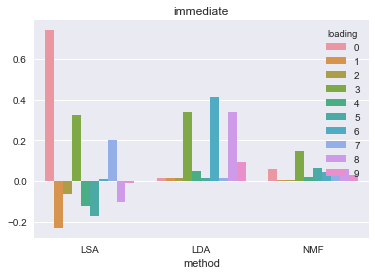

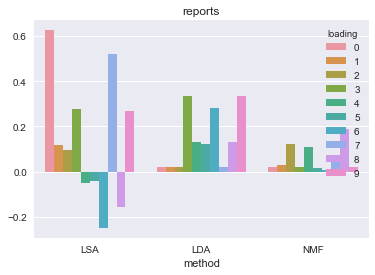

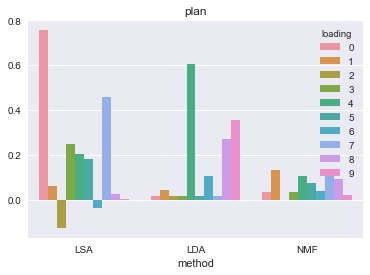

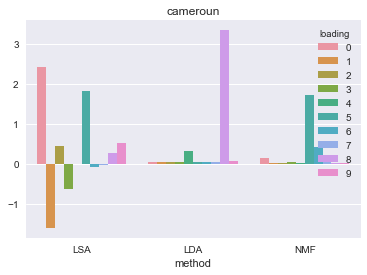

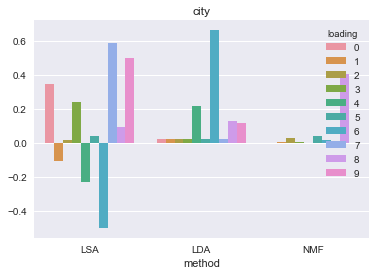

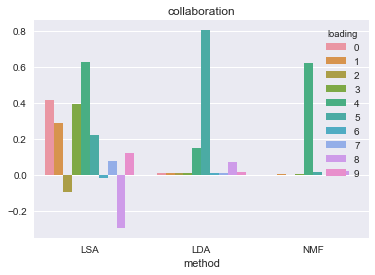

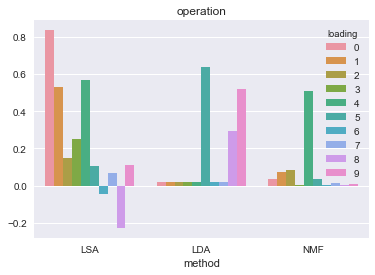

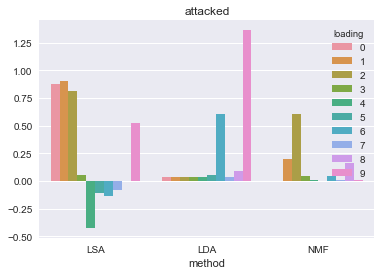

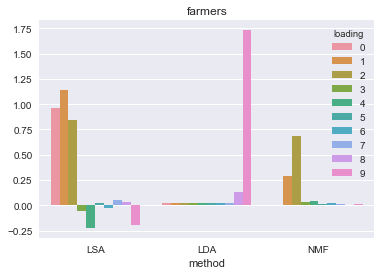

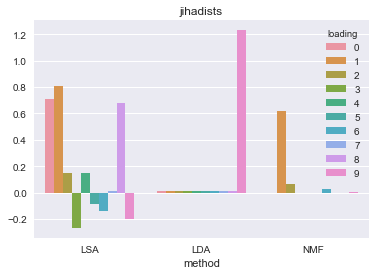

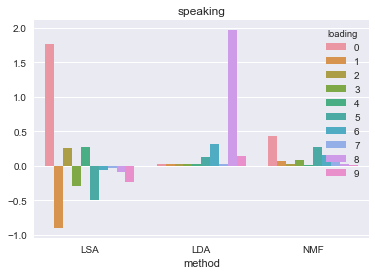

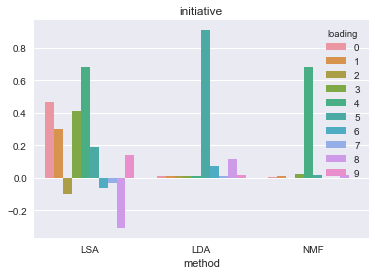

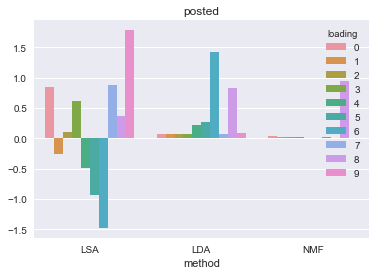

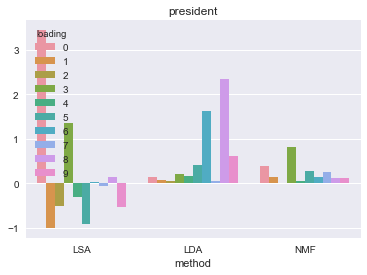

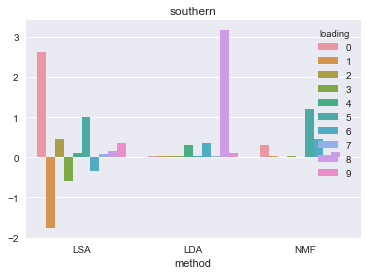

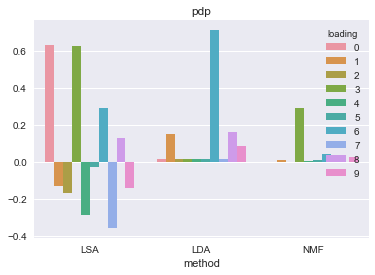

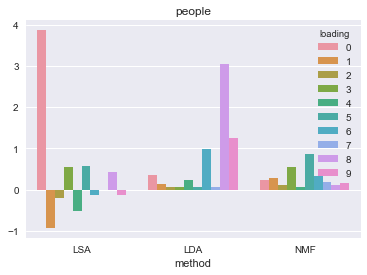

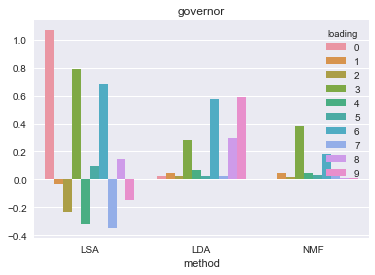

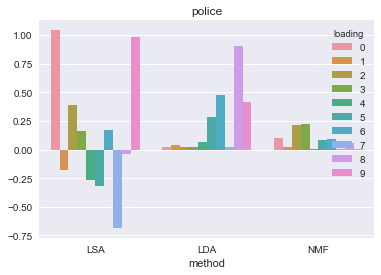

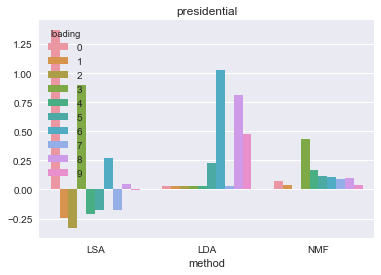

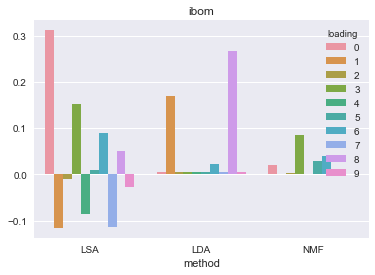

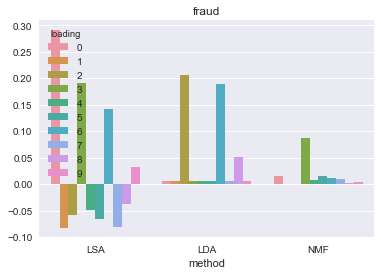

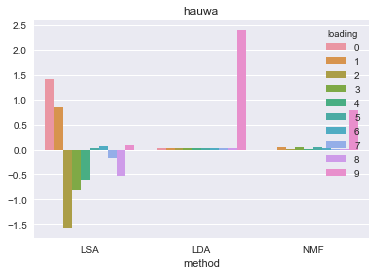

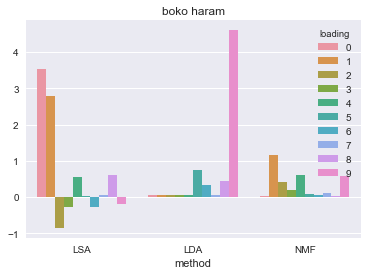

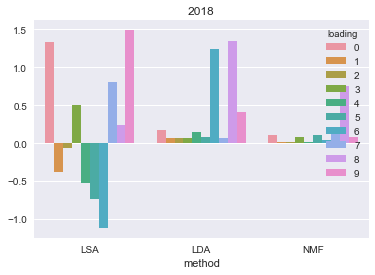

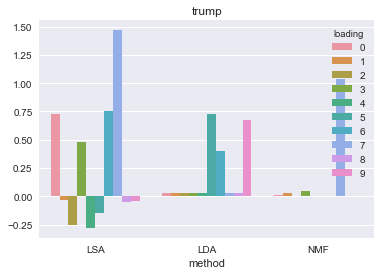

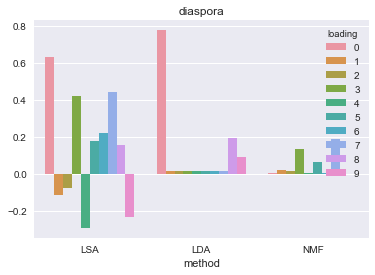

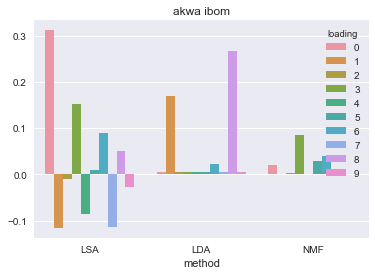

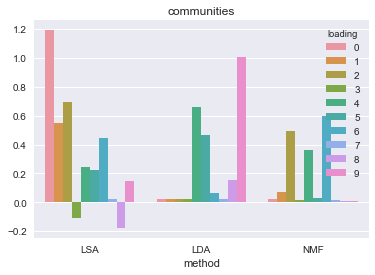

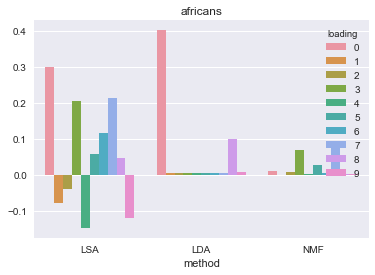

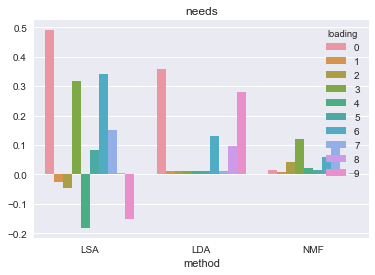

In [27]:
targetwords = list(set(words_allmethods_flat))

wordloadings=pd.DataFrame(columns=targetwords)
                  
for word in targetwords:
    loadings=components_lsa.loc[word].append(
        components_lda.loc[word]).append(
            components_nmf.loc[word])
    wordloadings[word]=loadings

wordloadings['method']=np.repeat(['LSA','LDA','NMF'], 10, axis=0)
wordloadings['loading']=[0,1,2,3,4,5,6,7,8,9]*3

sns.set(style="darkgrid")

for word in targetwords:
    sns.barplot(x="method", y=word, hue="loading", data=wordloadings)
    plt.title(word)
    plt.ylabel("")
    plt.show()